In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipypb import irange

In [2]:
def gym(players):
    n = len(players)
    base_coin = 21 - np.clip(n, 5, 7)*2
    replay = []
    finish = []
    place_value = list((np.arange(n) + 1)*20)
    place_value[0] -= 20
    place_value[-1] += 20

    def init():
        deck = np.arange(33) + 3
        np.random.shuffle(deck)
        deck = list(deck[:24])
        state = [[base_coin, []] for _ in range(n)]
        turn = np.random.randint(n)
        pot = None
        return state, turn, pot, deck
    
    def get_serial(state, turn, pot): # 0~55 (56) + 3~35 (33)
        s_rot = state[turn:] + state[:turn]
        out = np.zeros((n+1, 89), int)
        for i in range(n):
            out[i,s_rot[i][0]] = 1
            for c in s_rot[i][1]:
                out[i,c+53] = 1
        if pot is not None:
            out[-1,pot[0]] = 1
            out[-1,pot[1]+53] = 1
        return out

    def get_score(state, turn):
        sc = state[turn]
        out = sc[0]
        if len(sc[1]) > 0:
            out -= sc[1][0]
            for p, q in zip(sc[1][:-1], sc[1][1:]):
                if p+1 != q:
                    out -= q
        return out
    
    def play(state, turn, pot):
        sc = state[turn]
        s0, c0 = get_serial(state, turn, pot), get_score(state, turn)
        ans = sc[0] > 0 and players[turn](s0)
        if ans:
            sc[0] -= 1
            pot[0] += 1
        else:
            sc[0] += pot[0]
            sc[1].append(pot[1])
            sc[1].sort()
            pot = None
        s1, c1 = get_serial(state, turn, pot), get_score(state, turn)
        replay.append((c1-c0, s0, s1))
        return ans
        
    def run():
        state, turn, pot, deck = init()
        while len(deck) > 0:
            pot = [0, deck.pop()]
            while play(state, turn, pot): 
                turn = (turn + 1) % n
                
        scores = [get_score(state, i) for i in range(n)]
        for place, idx in enumerate(np.argsort(scores)):
            finish.append((get_serial(state, idx, None), scores[idx] + place_value[place]))
        
        return state
            
    return run, replay, finish

In [3]:
def luabot(s):
    rand = np.random.rand()
    if rand < 0.1: return True
    if rand > 0.9: return False
    
    s = [[i for i in range(89) if s_[i]] for s_ in s]
    s = [s_[:1] + [c - 53 for c in s_[1:]] for s_ in s]
    
    if s[-1][1] - s[-1][0] < 3: 
        return False
    if len(s[0]) > 1 and np.abs(np.r_[s[0][1:]] - s[-1][1]).min() == 1: 
        for i in range(1, len(s)-1):
            if len(s[0]) > 1 and np.abs(np.r_[s[0][1:]] - s[-1][1]).min() == 1:
                return False
        return s[-1][1] - s[-1][0] > 2*s[-1][0]
    if s[0][0] > 11: 
        return True
    return np.random.randint(1, s[-1][1]) > s[-1][0] + 10 - s[0][0]

In [4]:
run, replay, finish = gym([luabot for _ in range(5)])
run()

[[9, [3, 4, 7, 8, 9, 16, 22, 23, 24, 25, 33]],
 [11, [28, 29]],
 [7, [15, 19, 20, 30]],
 [13, [5, 6, 11, 21]],
 [15, [17, 32, 35]]]

In [5]:
for i in irange(9999):
    run()
len(replay), len(finish)

 [████████████████████████████████████████████████████████████] 9999/9999 [01:17<00:00, 0.01s/it]

(782017, 50000)

In [6]:
def save_epi(file, replay, finish):
    vc  = np.array([r[0] for r in replay])
    vs0 = np.array([r[1] for r in replay])
    vs1 = np.array([r[2] for r in replay])
    vf  = np.array([f[1] for f in finish])
    vsf = np.array([f[0] for f in finish])
    np.savez_compressed(file, vc=vc, vs0=vs0, vs1=vs1, vf=vf, vsf=vsf)
    return vc.shape, vs0.shape, vs1.shape, vf.shape, vsf.shape

In [7]:
def load_epi(file):
    obj = np.load(file)
    vc  = obj['vc']
    vs0 = obj['vs0']
    vs1 = obj['vs1']
    vf  = obj['vf']
    vsf = obj['vsf']
    return vc, vs0, vs1, vf, vsf

In [8]:
save_epi('r0.npz', replay, finish)

((782017,), (782017, 6, 89), (782017, 6, 89), (50000,), (50000, 6, 89))

In [9]:
vc, vs0, vs1, vf, vsf = load_epi('r0.npz')

In [10]:
vc.shape, vs0.shape, vs1.shape, vf.shape, vsf.shape

((782017,), (782017, 6, 89), (782017, 6, 89), (50000,), (50000, 6, 89))

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class DVN(nn.Module):
    def __init__(self, n=5):
        super(DVN, self).__init__()
        
        sz1 = (n+1)*89
        sz2 = (n+1)*40
        sz3 = (n+1)*20
        sz4 = (n+1)*10
        sz5 = (n+1)*5

        self.ds1 = nn.Linear(sz1, sz2)
        self.ds2 = nn.Linear(sz2, sz3)
        self.ds3 = nn.Linear(sz3, sz4)
        self.ds4 = nn.Linear(sz4, sz5)
        self.ds5 = nn.Linear(sz5, 1)
        
    def forward(self, x):
        x = F.relu(self.ds1(x - 0.5))
        x = F.relu(self.ds2(x))
        x = F.relu(self.ds3(x))
        x = F.relu(self.ds4(x))
        
        return self.ds5(x)

In [14]:
net = DVN(5)

In [15]:
def train_direct(net, x, y, epochs=10, batch_size=1024):
    n = x.shape[0]
    assert y.shape[0] == n
    net.train()
    history = []
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(net.parameters())
    
    x = x.reshape((n,-1))
    y = y.reshape((n,-1))
    
    for epoch in range(epochs):
        rndarg = np.arange(n)
        np.random.shuffle(rndarg)
        for batch in range(0, n, batch_size):
            x_batch = torch.from_numpy(x[rndarg[batch:][:batch_size]]).float()
            y_batch = torch.from_numpy(y[rndarg[batch:][:batch_size]]).float()
            loss = criterion(net(x_batch), y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        history.append(loss.data.cpu().numpy() + 0)
        clear_output(wait=True)
        plt.figure(figsize=(12,5))
        plt.plot(history, 'k.')
        plt.show()

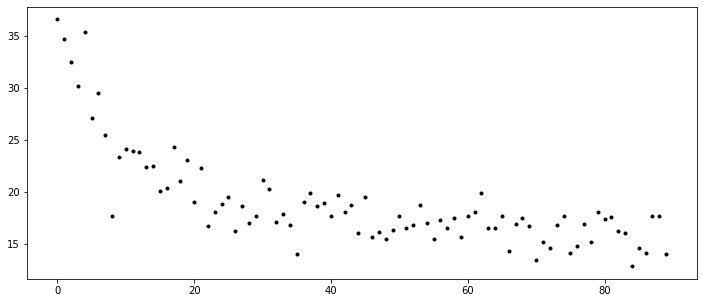

In [ ]:
train_direct(net, vsf, vf, epochs=300, batch_size=256)

In [ ]:
train_direct(net, vsf, vf, epochs=200, batch_size=512)

In [ ]:
train_direct(net, vsf, vf, epochs=100, batch_size=1024)

In [ ]:
vf_pred = net(torch.from_numpy(vsf.reshape((-1, 534))).float()).data.numpy().flatten()

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(vf_pred, vf, 'k.')
plt.show()